# Line Integral Convolution

In this assignment, we will be implementing Line Integral Convolution (LIC), a technique for visualizing the flow of 2D vector fields developed by Brian Cabral and Leith Leedom. This technique was discussed in Week 10 of the course.

See section 6.6 of *Data Visualization, 2nd Edition* by Alexandru C. Telea (accessible through UIUC Library sign-in at [this page](https://i-share-uiu.primo.exlibrisgroup.com/discovery/fulldisplay?docid=alma99944517012205899&context=L&vid=01CARLI_UIU:CARLI_UIU&tab=LibraryCatalog&lang=en)) or the Wikipedia page at https://en.wikipedia.org/wiki/Line_integral_convolution for additional overviews of the algorithm.

You can also refer to the original paper by Cabral and Leedom, which can be found [here](http://cs.brown.edu/courses/csci2370/2000/1999/cabral.pdf).

You should review one or more of the resources mentioned above **prior to** starting this assignment, as we expect a basic understanding of LIC before implementing the functions below.

As usual, we will begin by importing the necessary modules.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pylab as plt

The vector field that we will be working with for this assignment is defined below. The code below essentially produces an array of vortices. See the end of this assignment for what the final LIC image of this vector field should look like.

In [2]:
size = 300

vortex_spacing = 0.5
extra_factor = 2.0

a = np.array([1, 0]) * vortex_spacing
b = np.array([np.cos(np.pi / 3), np.sin(np.pi / 3)]) * vortex_spacing
rnv = int(2 * extra_factor / vortex_spacing)
vortices = [n * a + m * b for n in range(-rnv, rnv) for m in range(-rnv, rnv)]
vortices = [(x, y) for (x, y) in vortices if -extra_factor < x < extra_factor and -extra_factor < y < extra_factor]

xs = np.linspace(-1, 1, size).astype(np.float64)[None, :]
ys = np.linspace(-1, 1, size).astype(np.float64)[:, None]

vx = np.zeros((size, size), dtype = np.float64)
vy = np.zeros((size, size), dtype = np.float64)
for(x, y) in vortices:
    rsq = (xs - x)**2 + (ys - y)**2
    vx +=  (ys - y) / rsq
    vy += -(xs - x) / rsq

LIC takes as input a noisy image or texture defined over the domain of the vector field we want to visualize and outputs an image that is blurred along the streamlines of the vector field. We will thus need to trace the streamlines for every pixel in the texture.

In order to do so, let's first define and implement a function `advance` that will advance from one pixel to another in the direction of the vector associated with a given pixel within the vector field. This function should take 8 parameters:
- `x` and `y` indicate the coordinates of the pixel we're currently on. 
- `ux` and `uy` indicate the x and y components of the vector at the current pixel
- `fx` and `fy` indicate the current subpixel position (treating the current pixel as a unit square where `(0,0)` represents the top-left of the pixel, while `(1,1)` represents the bottom-right of the pixel).
- `nx` and `ny` indicate the total number of pixels along the x and y axes within the domain of the entire vector field.

`advance()` should return a 4-tuple consisting of updated `x`, `y`, `fx`, and `fy` values. These values should be updated by:
  1. reading the current pixel / subpixel position given by `x`, `y`, `fx`, and `fy`
  2. calculating `tx` and `ty` as the time it takes to reach the next pixel along each axis given `fx`, `fy`, `ux` and `uy`
  3. determining whether the next pixel reached will be on the x-axis or on the y-axis, and whether we are moving forward or backward along that axis
  4. using `tx`, `ty`, `ux`, `uy`, and the results of step (3) to update `x`, `y`, `fx`, and `fy` in the same order we cross pixel boundaries after `min(tx,ty)` units of time (i.e., advance far enough to cross a pixel boundary and no farther)
  
Your implementation should also handle the two special cases where `advance()` would return a pixel outside the vector field, or where `ux` and `uy` are both zero vectors. In the first case, `x` and `y` should just be clamped to the boundaries of the vector field. In the second case, you could actually interpolate the vector field value at that pixel, but for the purpose of this assignment, you can just return `None`. **Rounding should not be needed or used within your implementation**.

In [33]:
def advance(ux, uy, x, y, fx, fy, nx, ny):
    """
    Move to the next pixel in the direction of the vector at the current pixel.

    Parameters
    ----------
    ux : float
      Vector x component.
    uy :float
      Vector y component.
    x : int
      Pixel x index.
    y : int
      Pixel y index.
    fx : float
      Position along x in the pixel unit square.
    fy : float
      Position along y in the pixel unit square.
    nx : int
      Number of pixels along x.
    ny : int
      Number of pixels along y.
    
    Returns
    -------
    x : int
      Updated pixel x index.
    y : int
      Updated pixel y index.
    fx : float
      Updated position along x in the pixel unit square.
    fy : float
      Updated position along y in the pixel unit square.
    """
    x, y, fx, fy = x, y, fx, fy
    # Calculate the time it takes to reach the next pixel along the x-axis
    if ux < 0:
        tx = abs(fx / ux)
    elif ux > 0:
        tx = abs((1 - fx) / ux)
    # Calculate the time it takes to reach the next pixel along the y-axis
    if uy < 0:
        ty = abs(fy / uy)
    elif uy > 0:
        ty = abs((1 - fy) / uy)
    
    # Corner cases
    ## If both vector components equal 0
    if ux == 0 and uy == 0:
        tx = np.inf
        ty = np.inf
        return None
    if ux == 0 and uy != 0:
        tx = np.inf
    if uy == 0 and ux != 0:
        ty = np.inf
    ## If we attempt to move backward along the x-axis and we are at x = 0
    if tx < ty and ux < 0 and x == 0:
        fx = 1
        fy += (tx * uy)
        x = 0
        y = y
        return((x, y, fx, fy))
    ## If we attempt to move forward along the x-axis and we are at x = nx-1
    elif tx < ty and ux > 0 and x == (nx - 1):
        fx = 0
        fy += (tx * uy)
        x = nx - 1
        y = y
        return((x, y, fx, fy))
    ## If we attempt to move backward along the y-axis and we are at y = 0
    elif ty < tx and uy < 0 and y == 0:
        fx += (ty * ux)
        fy = 1
        y = 0
        x = x
        return((x, y, fx, fy))
    ## If we attempt to move forward along the y-axis and we are at y = ny-1
    elif ty < tx and uy > 0 and y == (ny - 1):
        fx += (ty * ux)
        fy = 0
        y = ny - 1
        x = x
        return((x, y, fx, fy))
    
    # If we are moving backward along the x-axis
    if tx < ty and ux < 0:
        fx = 1
        fy += (tx * uy)
        x -= 1
    # If we are moving forward along the x-axis
    elif tx < ty and ux > 0:
        fx = 0
        fy += (tx * uy)
        x += 1
    # If we are moving backward along the y-axis
    elif ty < tx and uy < 0:
        fx += (ty * ux)
        fy = 1
        y -= 1
    # If we are moving forward along the y-axis
    else:
        fx += (ty * ux)
        fy = 0
        y += 1
    

    return ((x, y, fx, fy))
    

In [34]:
# Sanity check

x_1, y_1, fx_1, fy_1 = advance(-19.09, 14.25, 0, 0, 0.5, 0.5, 10, 10)

np.testing.assert_allclose(x_1, 0, atol=0.01,rtol=0)
np.testing.assert_allclose(y_1, 0, atol=0.01,rtol=0)
np.testing.assert_allclose(fx_1, 1, atol=0.01,rtol=0)
np.testing.assert_allclose(fy_1, 0.873, atol=0.01,rtol=0)

x_2, y_2, fx_2, fy_2 = advance(14.25, -10.53, 1, 0, 0, 0.13, 10, 10)

np.testing.assert_allclose(x_2, 1, atol=0.01,rtol=0)
np.testing.assert_allclose(y_2, 0, atol=0.01,rtol=0)
np.testing.assert_allclose(fx_2, 0.176, atol=0.01,rtol=0)
np.testing.assert_allclose(fy_2, 1, atol=0.01,rtol=0)

x_3, y_3, fx_3, fy_3 = advance(-10.29, 10.59, 1, 1, 0.67, 0, 10, 10)

np.testing.assert_allclose(x_3, 0, atol=0.01,rtol=0)
np.testing.assert_allclose(y_3, 1, atol=0.01,rtol=0)
np.testing.assert_allclose(fx_3, 1, atol=0.01,rtol=0)
np.testing.assert_allclose(fy_3, 0.690, atol=0.01,rtol=0)

Next, let's define and implement the function `compute_streamline()`, which we will use to trace the streamline centered on a given pixel and apply the convolution kernel to the streamline. We will essentially take an average of the values at all of the pixels along the streamline (using the grey-values from our noisy input texture). These values should also be weighted by the kernel function, where the weight of the kernel function should decrease with distance away from the central pixel.

This function takes 6 parameters:
- `vx` and `vy` are 2D arrays containing the x- and y-components respectively of the vector field. 
- `px` and `py` indicate the coordinates of the pixel for which we are tracing the streamline.
- `texture` indicates the input 2D texture that will be distorted by the vector field
- `kernel` is a weighted convolution kernel (i.e., a 1D array symmetric around its middle element, where the middle element is the largest value and all other elements in the array are values decreasing with distance from the middle). The size of `kernel` is approximately `2L+1` where `L` is the fixed maximal distance in one direction (i.e. forward or backward) of the streamline.

The `compute_streamline()` function should return the weighted sum of values at each pixel along the streamline centered on `(px,py)` by doing the following:
  1. Initializing the subpixel position `(fx,fy)` to the center of the pixel `(px,py)`, where `fx` and `fy` function as in `advance()` above
  2. Computing a running weighted sum of pixel values along a streamline, using `advance` to move to each next pixel in the streamline in either direction. Should be able to handle:
    * Center pixel
    * Forward direction (starting from center pixel, increasing to maximal distance L)
    * Backward direction (starting from center pixel, decreasing to -L) (*hint*: negate the vector passed to `advance()`)
    
As before, you will need to handle the case of a zero vector (i.e., whenever it returns `None`) by halting forward / backward iteration along the streamline. 

You may assume that the shape of `vx`, `vy`, and `texture` are all identical. Also, note that the **2D arrays `vx`, `vy`, and `texture` are stored in memory in `(y,x)` order**, so be sure to index them properly.  As before, rounding should not be needed or used within your implementation.

For reference, this function is effectively computing the numerator of Equation 6.14 in Section 6.6 of the [*Data Visualization* textbook](https://i-share-uiu.primo.exlibrisgroup.com/discovery/fulldisplay?docid=alma99944517012205899&context=L&vid=01CARLI_UIU:CARLI_UIU&tab=LibraryCatalog&lang=en). 

A visual reference from the textbook has been included below as well.

<img src="fig6-24.png" width=480px>

In [35]:
def compute_streamline(vx, vy, texture, px, py, kernel):
    '''
    Return the convolution of the streamline for the given pixel (px, py).
    
    Parameters
    ----------
    vx : array (ny, nx)
        Vector field x component.
    vy : array (ny, nx)
        Vector field y component.
    texture : array (ny, nx)
        The input texture image that will be distorted by the vector field.
    px : int
        Pixel x index
    py : int
        Pixel y index
    kernel : 1D array
        The convolution kernel: an array weighting the texture along the streamline.
        The kernel should be symmetric.
    fx : float
        Position along x in the pixel unit square
    fy : float
        Position along y in the pixel unit square
    nx : int
        Number of pixels along x-axis.
    ny : int
        Number of pixels along y-axis.
        
    Returns
    -------
    sum : float
        Weighted sum of values at each pixel along the streamline that starts at center of pixel (px, py)
    '''
    # Initialize the subpixel position (fx, fy) to the center of the starting pixel (px, py)
    fx, fy = 0.5, 0.5
    # Initialize the number of pixels along the x-axis and y-axis to be the shape of the input texture image along those axes.
    nx, ny = texture.shape[1], texture.shape[0]
    # Initialize x and y to be the coordinates of the starting pixel from the input texture image
    x, y = px, py
    # Initialize the pixel_values to an empty list
    p_vals = []
    # Initialize the weighted sum to be 0.0
    weighted_sum = 0.0
    p_vals.append(texture[y][x])

    for i in range(L, kernel.shape[0]):
        if(len(p_vals) == L + 1):
            break
        x, y, fx, fy = advance(vx[y, x], vy[y, x], x, y, fx, fy, nx, ny)
        p_vals.append(texture[y][x])
 
    x, y = px, py
    fx, fy = 0.5, 0.5
    x, y, fx, fy = advance(-vx[y, x], -vy[y, x], x, y, fx, fy, nx, ny)
    
    for i in range(L, kernel.shape[0]):
        if(len(p_vals) == 2*L + 1):
            break
        p_vals.insert(0, texture[y][x])
        x, y, fx, fy = advance(-vx[y, x], -vy[y, x], x, y, fx, fy, nx, ny)
            
        
    p_vals = np.array(p_vals)
    weighted_sum = np.dot(kernel, p_vals)
    
    return weighted_sum

In [36]:
# Sanity check
size_test = 100

# Generate 100x100 random noise texture
np.random.seed(123)
texture = np.random.rand(size_test, size_test).astype(np.float64)

# Regenerate vector field with new dimensions
xs = np.linspace(-1,1,size_test).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size_test).astype(np.float64)[:,None]

vx = np.zeros((size_test,size_test),dtype=np.float64)
vy = np.zeros((size_test,size_test),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq
    
# Generate sinusoidal kernel function
L = 5 #Radius of the kernel
kernel = np.sin(np.arange(2*L+1)*np.pi/(2*L+1)).astype(np.float64)

np.testing.assert_allclose(compute_streamline(vx, vy, texture, 9, 9, kernel), 3.622, atol=0.01,rtol=0)
np.testing.assert_allclose(compute_streamline(vx, vy, texture, 30, 82, kernel), 5.417, atol=0.01,rtol=0)
np.testing.assert_allclose(compute_streamline(vx, vy, texture, 99, 99, kernel), 4.573, atol=0.01,rtol=0)

Finally, we will define and implement a function `lic()` that returns a 2D array corresponding to an image distorted by a vector field using some symmetric convolution kernel. As in the `compute_streamline()` function above:
- `vx` and `vy` are 2D arrays containing the x- and y-components respectively of some vector field
- `texture` indicates the input 2D texture that will be distorted by the vector field
- `kernel` is the weighted convolution kernel itself.

The `lic()` function should just iterate over each pixel in `texture`, computing the streamline at that pixel by using the output of `compute_streamline()` and normalizing it with respect to the sum of weights within `kernel` (i.e., computing the denominator of Equation 6.14 referenced above). Once again, rounding should not be needed or used within your implementation.

In [46]:
def lic(vx, vy, texture, kernel):
    '''
    Return an image of the texture array blurred along the local vector field orientation.
    
    Parameters
    ----------
    vx : array(ny, nx)
        Vector field x component
    vy : array(ny, nx)
        Vecrtor fiedl y component
    texture : array(ny, nx)
        The input texture image that will be distorted by the vector field
    kernel : 1D array
        The convolution kernel: an array weighting the texture along the streamline.
        The kernel should be symmetric.
        
    Returns 
    -------
    result : array(ny, nx)
        An image of the texture convoluted along the the vector field streamlines.
    '''
    nx, ny = texture.shape[1], texture.shape[0]
    result = np.zeros([ny, nx]).astype(np.float64)
    
    for i in range(texture.shape[0]):
        for j in range(texture.shape[1]):
            #print(f'Current index: {(i, j)}')
            result[i][j] = compute_streamline(vx, vy, texture, i, j, kernel) / np.sum(kernel)
            #print(result[i][j])
            
    return np.transpose(result)

In [47]:
# Sanity check
size_test = 100

# Generate 100x100 random noise texture
np.random.seed(123)
texture = np.random.rand(size_test, size_test).astype(np.float64)

# Regenerate vector field with new dimensions
xs = np.linspace(-1,1,size_test).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size_test).astype(np.float64)[:,None]

vx = np.zeros((size_test,size_test),dtype=np.float64)
vy = np.zeros((size_test,size_test),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq
    
# Generate sinusoidal kernel function
L = 5 #Radius of the kernel
kernel = np.sin(np.arange(2*L+1)*np.pi/(2*L+1)).astype(np.float64) 

result = lic(vx, vy, texture, kernel)

np.testing.assert_allclose(result[50][50], 0.566, atol=0.01,rtol=0)
np.testing.assert_allclose(result[99][99], 0.657, atol=0.01,rtol=0)
np.testing.assert_allclose(result[28][36], 0.405, atol=0.01,rtol=0)

We are now ready to test our line integral convolution!  Below, we create a 300 x 300 array of random pixel noise.

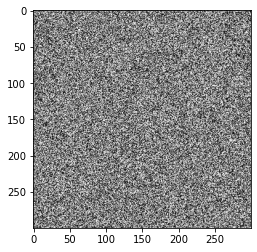

In [48]:
size = 300

np.random.seed(123)
texture = np.random.rand(size, size).astype(np.float64)
plt.imshow(texture, cmap = 'gray')

Now let's regenerate our vector field (defined at the top of the notebook) to match the dimensions of our texture.

In [49]:
xs = np.linspace(-1,1,size).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size).astype(np.float64)[:,None]

vx = np.zeros((size,size),dtype=np.float64)
vy = np.zeros((size,size),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq

We will use the same sinusoidal kernel as with the tests for each function, but this time we will set the maximal distance `L` to be 10. This means the size of the kernel will be 2*L+1 = 21.

In [50]:
L = 10 # Radius of the kernel
kernel = np.sin(np.arange(2*L+1)*np.pi/(2*L+1)).astype(np.float64)

Finally, we will generate a new image using our kernel function, vector field, and random noise texture as all defined above. 

Please note that depending on how you implemented the functions above, generating this image may take anywhere between 5 and 60 seconds.

In [51]:
image = lic(vx, vy, texture, kernel)

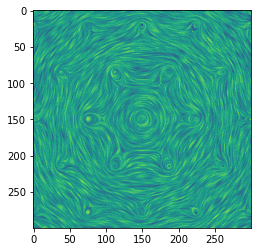

In [52]:
plt.imshow(image, cmap='viridis')

If your implementation is correct, you should see an image very similar to the one below.

<img src='lic-image.PNG' width="300"/>. 


This basic implementation of LIC does not consider the magnitude of the vectors or their sign. You can further experiment with this implementation by using magnitude to color the image, for example. The end of the lecture video on LIC provides a brief explanation for how you can do so.